In [1]:
import numpy as np
import pandas as pd

Load Travis' table

In [2]:
df = pd.read_csv("../../data/All_KepStars_For_Ruth_McQuillan_Analysis.csv")

In [3]:
df.head()

,KIC,source_id,plx,plxe,g_final,g_final_err,g_prov_final,Kmag,e_Kmag,[Fe/H]i,n_[Fe/H]i,_RA,_DE
0,757076,2050233807328471424,0.001524,0.000048,12.350957,0.020306,g_kic_fixed,9.559,0.017,-0.083,KIC,291.03873,36.59813
1,757099,2050233601176543104,0.002708,0.000027,13.704047,0.020015,g_kis_fixed,11.094,0.018,-0.208,KIC,291.04306,36.59381
2,757137,2050230543159814656,0.001753,0.000025,10.052258,0.027917,g_kic_fixed,6.722,0.017,-0.079,KIC,291.05588,36.55995
3,757280,2050230611879323904,0.001214,0.000022,12.132906,0.020044,g_kic_fixed,10.627,0.018,-0.231,KIC,291.09540,36.56494
4,757450,2050231848829944320,0.001199,0.000026,15.894970,0.020246,g_kis_fixed,13.118,0.029,0.229,SPE,291.13760,36.57738


Crossmatch with the McQuillan catalogue.

In [4]:
url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)
mc.head()

,KID,Teff,logg,Mass,Prot,Prot_err,Rper,LPH,w,DC,Flag
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,---
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,---
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,---
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,---
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,---


In [5]:
mcdf = pd.merge(df, mc, left_on="KIC", right_on="KID", how="inner")
print(np.shape(df), np.shape(mc), np.shape(mcdf))

(179688, 13) (34030, 11) (30087, 24)


Calculate Av

In [6]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 24.015 s
  pix_info:   0.542 s
   samples:  11.474 s
      best:   5.406 s
       nan:   0.063 s
      sort:   6.303 s
       idx:   0.226 s


In [7]:
coords = SkyCoord(mcdf._RA.values*units.deg, mcdf._DE.values*units.deg,
                  distance=(1./mcdf.plx.values)*units.pc, frame='galactic')

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.], return_flags=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [8]:
Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
print(np.shape(mcdf), np.shape(Av))

(30087, 24) (30087,)


In [9]:
mcdf["Av_flags"] = flags
mcdf["Av"] = Av
mcdf["Av_errp"] = Av_errp
mcdf["Av_errm"] = Av_errm

Let's try running stardate on one of these stars.

In [10]:
import stardate as sd

Only use metallicities if they're spectroscopic.

In [42]:
i = 0
if mcdf["n_[Fe/H]i"][i] == "SPE":
    iso_params = {"g": (df.g_final[i], df.g_final_err[i]),
                  "K": (df.Kmag[i], df.e_Kmag[i]),
                  "feh": (mcdf["[Fe/H]i"][i], .05),
                  "parallax": (df.plx[i]*1e3, df.plxe[i]*1e3)}
else:
    iso_params = {"g": (df.g_final[i], df.g_final_err[i]),
                  "K": (df.Kmag[i], df.e_Kmag[i]),
                  "parallax": (df.plx[i]*1e3, df.plxe[i]*1e3)}
    
print(iso_params)

star = sd.Star(iso_params, prot=mcdf.Prot[i], prot_err=mcdf.Prot[i]*.05,
               Av=mcdf.Av[i], Av_err=mcdf.Av_errp[i],
               savedir="posteriors", filename="test")

{'g': (12.3509565, 0.020305591508), 'K': (9.559, 0.017), 'parallax': (1.5239, 0.0483)}


In [43]:
star.fit(max_n=10000, thin_by=1000)

100%|██████████| 10000/10000 [01:23<00:00, 123.62it/s]


In [44]:
from stardate import load_samples, read_samples

# Load the samples.
flatsamples, _3Dsamples = load_samples("posteriors/test.h5", burnin=1)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)

# Print the results as a pandas dataframe.
results

,EEP_med,EEP_errm,EEP_errp,EEP_std,EEP_ml,age_med_gyr,age_errm,age_errp,age_std,age_ml_gyr,...,distance_errm,distance_errp,distance_std_pc,distance_ml,Av_med,Av_errm,Av_errp,Av_std,Av_ml,index
0,350.892221,30.062568,30.059175,31.707915,342.95417,0.314997,0.24567,0.521446,0.340369,0.214294,...,19.213656,22.561041,20.128744,653.404274,0.178211,0.01012,0.008633,0.009256,0.173213,0


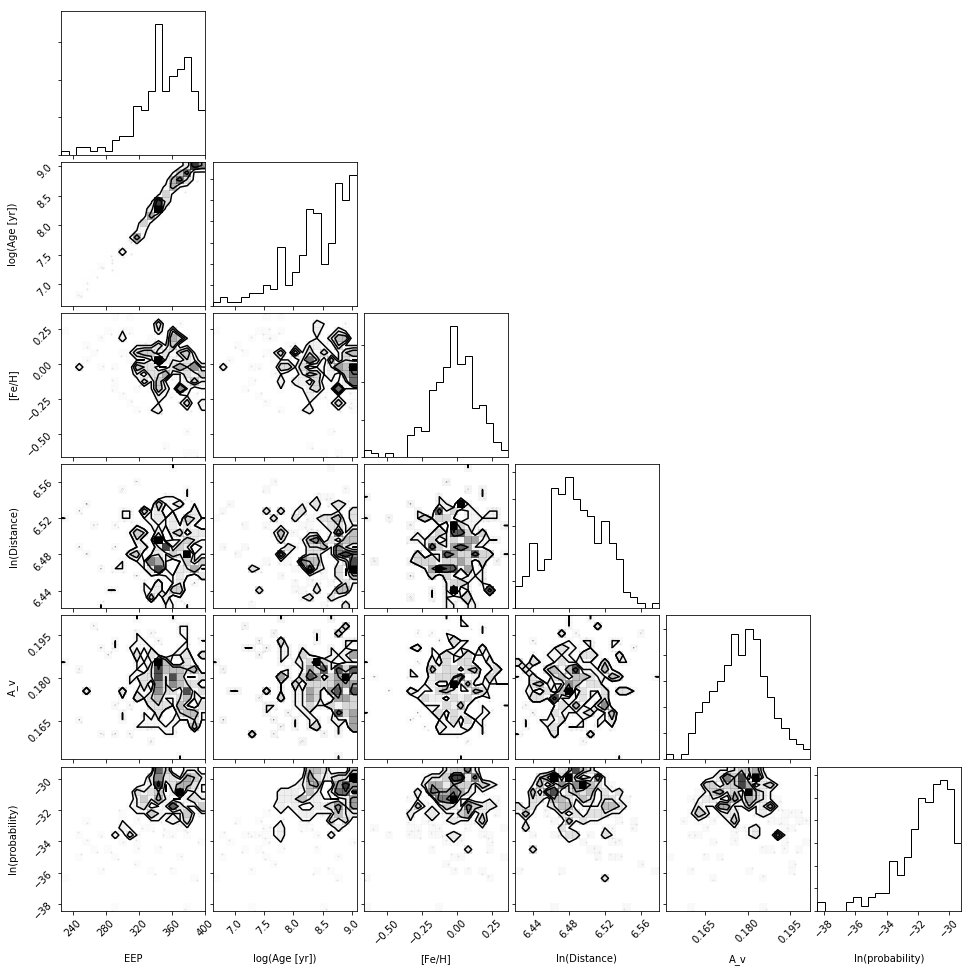

In [45]:
import corner

labels = ["EEP", "log(Age [yr])", "[Fe/H]", "ln(Distance)", "A_v", "ln(probability)"]

corner.corner(flatsamples, labels=labels);